<a href="https://colab.research.google.com/github/zafor158/Spark-Tutorial-in-pySpark/blob/main/Spark_Tutorial_in_pySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE488
## Spark Tutorial in pySpark

In this tutorial you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

Credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL.

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel.

In [ ]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's initialize the Spark context.


In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2024-11-28 02:46:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 75.2.60.68, 99.83.220.108, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  21.7MB/s    in 0.6s    

2024-11-28 02:46:29 (21.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


# Vietnam War

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets:

In [ ]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

##If you complete upto this point, raise your hand

##then execute the following line in the next code cell

##Showing the schema

In [ ]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [ ]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



##The following line shows the formatted output from json file

##Complete upto this. I will be back soon.

In [ ]:
Bombing_Operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

In [ ]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [ ]:
Aircraft_Glossary.take(5)

[Row(AirCraft='A-1', AirCraftName='Douglas A-1 Skyraider', AirCraftType='Fighter Jet'),
 Row(AirCraft='A-26', AirCraftName='Douglas A-26 Invader', AirCraftType='Light Bomber'),
 Row(AirCraft='A-37', AirCraftName='Cessna A-37 Dragonfly', AirCraftType='Light ground-attack aircraft'),
 Row(AirCraft='A-4', AirCraftName='McDonnell Douglas A-4 Skyhawk', AirCraftType='Fighter Jet'),
 Row(AirCraft='A-5', AirCraftName='North American A-5 Vigilante', AirCraftType='Bomber Jet')]

##Projecting columns

In [ ]:
Aircraft_Glossary.select("AirCraft","AirCraftname").show()

+--------+--------------------+
|AirCraft|        AirCraftname|
+--------+--------------------+
|     A-1|Douglas A-1 Skyra...|
|    A-26|Douglas A-26 Invader|
|    A-37|Cessna A-37 Drago...|
|     A-4|McDonnell Douglas...|
|     A-5|North American A-...|
|     A-6|Grumman A-6 Intruder|
|     A-7|  LTV A-7 Corsair II|
|  AC-119|Fairchild AC-119 ...|
|  AC-123|Fairchild C-123 P...|
|  AC-130|Lockheed AC-130 S...|
|   AC-47|Douglas AC-47 Spooky|
|    AH-1| Bell AH-1 HueyCobra|
|     B-1| Rockwell B-1 Lancer|
|    B-52| B-52 Stratofortress|
|    B-57|Martin B-57 Canberra|
|    B-66|Douglas B-66 Dest...|
|     C-1| Grumman C-1A Trader|
|   C-117|     C-117D Skytrain|
|   C-119|Fairchild C-119 F...|
|   C-123|Fairchild C-123 P...|
+--------+--------------------+
only showing top 20 rows



##Selecting Tuples (where clause in SQL)

In [ ]:
Aircraft_Glossary.where(Aircraft_Glossary.AirCraft=="A-1").show()

+--------+--------------------+------------+
|AirCraft|        AirCraftName|AirCraftType|
+--------+--------------------+------------+
|     A-1|Douglas A-1 Skyra...| Fighter Jet|
+--------+--------------------+------------+



In [ ]:
df_a_1= Bombing_Operations.where("Aircraft=='A-1'").show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|     A-1|UNITED STATES OF ...| 1970-02-02|              NULL|          N|  NAKHON PHANOM|         LAOS|      1415.0|BLU27 FIRE BOMB (...|              17400|
|     A-1|     VIETNAM (SOUTH)| 1972-04-29|              NULL|          D|       BIEN HOA|SOUTH VIETNAM|       700.0|                NULL|              84960|
|     A-1|     VIETNAM (SOUTH)| 1972-08-02|              NULL|       NULL|       BIEN HOA|SOUTH VIETNAM|         0.0|                NULL|                  0|
|     A-1|     VIETNAM (SOUTH)| 1970-04-27|   

In [ ]:
df_a_1= Bombing_Operations.where("Aircraft=='A-1'")

In [ ]:
df_a_1.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|     A-1|UNITED STATES OF ...| 1970-02-02|              NULL|          N|  NAKHON PHANOM|         LAOS|      1415.0|BLU27 FIRE BOMB (...|              17400|
|     A-1|     VIETNAM (SOUTH)| 1972-04-29|              NULL|          D|       BIEN HOA|SOUTH VIETNAM|       700.0|                NULL|              84960|
|     A-1|     VIETNAM (SOUTH)| 1972-08-02|              NULL|       NULL|       BIEN HOA|SOUTH VIETNAM|         0.0|                NULL|                  0|
|     A-1|     VIETNAM (SOUTH)| 1970-04-27|   

In [ ]:
Aircraft_Glossary.where(Aircraft_Glossary.AirCraft=="A-1").collect() # Collect -- RDD create kore

[Row(AirCraft='A-1', AirCraftName='Douglas A-1 Skyraider', AirCraftType='Fighter Jet')]

In [ ]:
Aircraft_Glossary.where("AirCraft == 'A-1'").show()

+--------+--------------------+------------+
|AirCraft|        AirCraftName|AirCraftType|
+--------+--------------------+------------+
|     A-1|Douglas A-1 Skyra...| Fighter Jet|
+--------+--------------------+------------+



Solve the folowing queries:

1.Find all aircrafts of type "Light Bomber"

2.Find all bombing missions operated by "VIETMAN (SOUTH)"

3.Find aircraft, ,mission data, country Flying mission of those attacks in which the Take off location was "UDORN AB"

4.Find all bombing operation on the year 1971

5.Find the number of missions operated by each aircraft

6.Find the maximum attack time operated by each aircraft

7.Find the maximum attack time operated by each aircraft on a different target country

In [ ]:
q1=Aircraft_Glossary.where("AirCraftType == 'Light Bomber'")
q1.show()

In [ ]:
q2= Bombing_Operations.where("ContryFlyingMission == 'VIETNAM (SOUTH)'")
q2.show()

In [ ]:
q3=Bombing_Operations.where("TakeoffLocation == 'UDORN AB'").select("Aircraft", "MissionDate", "ContryFlyingMission")
q3.show()

In [ ]:
q4 = Bombing_Operations.where(year(Bombing_Operations.MissionDate) == 1971)
q4_1=Bombing_Operations.where("MissionDate >= '1971-01-01' AND MissionDate<=1971")
#q4.show()
q4_1.show()

In [ ]:
q5=Bombing_Operations.groupBy("Aircraft").count()
q5.sort("Aircraft").show()

+--------+------+
|Aircraft| count|
+--------+------+
|     A-1|358498|
|    A-26| 36242|
|     A-3|  1213|
|    A-37|267457|
|     A-4|372975|
|     A-5|     8|
|     A-6|144601|
|     A-7|165773|
|      A8|     4|
|  AC-119| 76525|
|  AC-123|  3434|
|  AC-130| 75058|
|   AC-47| 73843|
|    AH-1|  1292|
|   AU-24|  5036|
|     B-1|     2|
|    B-52| 99100|
|    B-57| 82219|
|    B-66|  1052|
|     C-1|    39|
+--------+------+
only showing top 20 rows



In [ ]:
q6 = Bombing_Operations.groupBy("Aircraft").agg(max("TimeOnTarget").alias("MaximumAttackTime"))
q6.show()

+--------+-----------------+
|Aircraft|MaximumAttackTime|
+--------+-----------------+
|     E-2|           2400.0|
|  LC-130|            800.0|
|     F-5|           2400.0|
|   OV-10|           2359.0|
|    U-1A|            200.0|
|     E-3|            800.0|
|   HC-47|           1720.0|
|  EC-130|           2359.0|
|    KA-4|           2235.0|
|    HH-3|            801.0|
|    TA-4|           2359.0|
|  EC-121|           2359.0|
|      T9|            250.0|
|  AC-123|           2145.0|
|    C-76|            800.0|
|    OV-1|           1510.0|
|  VC-118|            800.0|
|   UH-34|              0.0|
|    B-57|           2500.0|
|    U-17|           2000.0|
+--------+-----------------+
only showing top 20 rows



In [ ]:
q7 = Bombing_Operations.groupBy("Aircraft", "ContryFlyingMission").agg(max("TimeOnTarget").alias("MaximumAttackTime"))
q7.show()

+---------+--------------------+-----------------+
| Aircraft| ContryFlyingMission|MaximumAttackTime|
+---------+--------------------+-----------------+
|      U-6|     VIETNAM (SOUTH)|            900.0|
|NOT CODED|UNITED STATES OF ...|           2250.0|
|   UC-123|UNITED STATES OF ...|           2359.0|
|    FC-47|UNITED STATES OF ...|           2400.0|
|     B-57|           AUSTRALIA|           2359.0|
|     KA-6|UNITED STATES OF ...|           1800.0|
|   RF-101|UNITED STATES OF ...|           4830.0|
|      E-2|UNITED STATES OF ...|           2400.0|
|     T-28|                LAOS|           2355.0|
|      A-7|UNITED STATES OF ...|           2359.0|
|     RF-8|UNITED STATES OF ...|           9735.0|
|    VC-54|UNITED STATES OF ...|            800.0|
|   LC-130|UNITED STATES OF ...|            800.0|
|      E-1|UNITED STATES OF ...|           2350.0|
|    C-119|     VIETNAM (SOUTH)|            900.0|
|      F-5|     VIETNAM (SOUTH)|           2357.0|
|    AC-47|       KOREA (SOUTH)

##Counting the number of rows

In [ ]:
Bombing_Operations.count()

4400775

In [ ]:
Aircraft_Glossary.count()

104

In [ ]:
print("There are %d aircrafts" % (Aircraft_Glossary.count()))

There are 104 aircrafts


##Writing Queries

**1.Find the aircraft model and the mission date for the operations took place over LAOS (target country).**

**2. Find the aircraft model, the mission date and take off location for the operations took place over LAOS (target country) and duration was more than 1000.**

In [ ]:
df_q1 = Bombing_Operations.where("TargetCountry = 'LAOS'").select("AirCraft", "MissionDate")

In [ ]:
df_q1.count()

1254695

In [ ]:
df_q1.show()

+--------+-----------+
|AirCraft|MissionDate|
+--------+-----------+
|    RF-4| 1973-07-28|
|     A-1| 1970-02-02|
|     F-4| 1970-11-25|
|     A-4| 1972-03-08|
|     F-4| 1971-12-27|
|     A-6| 1971-05-12|
|   EB-66| 1971-12-03|
|    T-28| 1971-12-19|
|     F-4| 1972-01-01|
|    RF-4| 1972-01-08|
|   F-105| 1970-10-02|
|    RF-4| 1970-12-08|
|     F-4| 1971-06-23|
|     A-6| 1971-08-11|
|    T-28| 1972-05-07|
|     A-7| 1973-02-24|
|    B-52| 1972-02-21|
|     A-7| 1973-02-17|
|     F-4| 1970-05-14|
|     F-4| 1971-02-13|
+--------+-----------+
only showing top 20 rows



In [ ]:
df_q2 = Bombing_Operations.where("TargetCountry = 'LAOS' AND TimeOnTarget > 1000").select("AirCraft", "MissionDate","TakeOffLocation")

In [ ]:
df_q2.show()

+--------+-----------+---------------+
|AirCraft|MissionDate|TakeOffLocation|
+--------+-----------+---------------+
|     A-1| 1970-02-02|  NAKHON PHANOM|
|     A-4| 1972-03-08|    TONKIN GULF|
|     A-6| 1971-05-12|    TONKIN GULF|
|   EB-66| 1971-12-03|          KORAT|
|   F-105| 1970-10-02|         TAKHLI|
|     A-7| 1973-02-24|          KORAT|
|    B-52| 1972-02-21|        U TAPAO|
|   C-130| 1970-01-16|        UBON AB|
|    B-57| 1971-06-24|        UBON AB|
|  AC-119| 1971-11-05|        UBON AB|
|  AC-130| 1972-03-01|        UBON AB|
|  AC-130| 1971-04-21|        UBON AB|
|     F-4| 1970-11-16|          KORAT|
|   AC-47| 1973-01-18|     SAVANAKHET|
|  AC-130| 1971-04-26|        UBON AB|
|   AC-47| 1972-01-13|      LONG TIEN|
|     F-4| 1970-02-03|         DANANG|
|  AC-130| 1970-01-18|        UBON AB|
|   QU-22| 1971-06-29|  NAKHON PHANOM|
|     F-4| 1970-04-02|       UDORN AB|
+--------+-----------+---------------+
only showing top 20 rows



In [ ]:
df_q2.count()

546126

##Aggregates and Sorting

**3. Number of missions for each country operating the missions (ContryFlyingMission)**

**4. Find the average duration (TimeOnTarget) for each target country. Sort the result based on the Target Country Name**

**5. Find the average duration (TimeOnTarget) for each target country per day. Sort the result according to mission date**



In [ ]:
df_q3 = Bombing_Operations.groupBy("ContryFlyingMission").agg(count("*").alias("NumberOfMissions"))

In [ ]:
df_q3.sort(desc("NumberOfMissions")).show()

+--------------------+----------------+
| ContryFlyingMission|NumberOfMissions|
+--------------------+----------------+
|UNITED STATES OF ...|         3708997|
|     VIETNAM (SOUTH)|          622013|
|                LAOS|           32777|
|       KOREA (SOUTH)|           24469|
|           AUSTRALIA|           12519|
+--------------------+----------------+



In [ ]:
df_q5 = Bombing_Operations.groupBy(["MissionDate","TargetCountry"]).agg(avg("TimeOnTarget").alias("Avg.Time")).sort("MissionDate","TargetCountry")

In [ ]:
df_q5.show()

+-----------+-------------+------------------+
|MissionDate|TargetCountry|          Avg.Time|
+-----------+-------------+------------------+
| 1965-10-01|         LAOS|            1203.0|
| 1965-10-01|NORTH VIETNAM| 1183.111111111111|
| 1965-10-01|SOUTH VIETNAM|1275.3181818181818|
| 1965-10-02|         LAOS|1351.0833333333333|
| 1965-10-02|NORTH VIETNAM|1235.1684981684982|
| 1965-10-02|SOUTH VIETNAM|1216.1370262390672|
| 1965-10-03|         LAOS|1037.7777777777778|
| 1965-10-03|NORTH VIETNAM|1144.1968503937007|
| 1965-10-03|SOUTH VIETNAM| 1267.709480122324|
| 1965-10-04|         LAOS| 998.3181818181819|
| 1965-10-04|NORTH VIETNAM|1281.5868725868727|
| 1965-10-04|SOUTH VIETNAM|1131.0796812749004|
| 1965-10-05|         LAOS|1301.1666666666667|
| 1965-10-05|NORTH VIETNAM| 1240.695652173913|
| 1965-10-05|SOUTH VIETNAM|1239.5200803212851|
| 1965-10-06|         LAOS|1190.0461538461539|
| 1965-10-06|NORTH VIETNAM| 981.1253918495298|
| 1965-10-06|SOUTH VIETNAM|1266.1638418079096|
| 1965-10-07|

##Tranforming on Pandas DataFrame

In [ ]:
mission_count_pd = df_q3.toPandas()
mission_count_pd.head()

,ContryFlyingMission,NumberOfMissions
0,VIETNAM (SOUTH),622013
1,KOREA (SOUTH),24469
2,UNITED STATES OF AMERICA,3708997
3,AUSTRALIA,12519
4,LAOS,32777


<Axes: xlabel='ContryFlyingMission'>

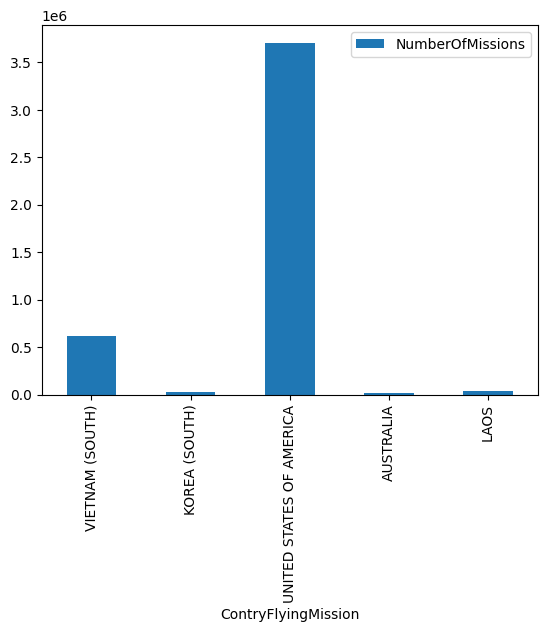

In [ ]:
mission_count_pd.plot(kind="bar", x= "ContryFlyingMission", y="NumberOfMissions")

##Writing RAW SQL Queries

In [ ]:
Bombing_Operations.createOrReplaceTempView("Bombing_operations")

query = """ SELECT ContryFlyingMission, count(*) as NumberOfMissions
            FROM Bombing_Operations
            GROUP BY ContryFlyingMission
            ORDER BY NumberOfMissions desc
        """

missions_count = spark.sql(query)


In [ ]:
missions_count.show()

+--------------------+----------------+
| ContryFlyingMission|NumberOfMissions|
+--------------------+----------------+
|UNITED STATES OF ...|         3708997|
|     VIETNAM (SOUTH)|          622013|
|                LAOS|           32777|
|       KOREA (SOUTH)|           24469|
|           AUSTRALIA|           12519|
+--------------------+----------------+



**We will keep working on the previous Colab Notebook of Lab 05.**

**Notebook Link is given in Classroom**

**Make sure that you have saved the copy and executes all the cell first**

**Also upload all the files (csv, txt) given in Datasets folder in the Google Drive**

1. Implementing Join over Standard DataFrame

2. Demonstrating RDD APIs (e.g. Map, Reduce etc.)

In [ ]:
print(Bombing_Operations.show())

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

In [ ]:
print(Aircraft_Glossary.show())

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

Performing a Join Between these two data frames

In [ ]:
join_results = Bombing_Operations.join(Aircraft_Glossary, Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)

In [ ]:
join_results.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------+--------------------+--------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------+--------------------+--------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|   EC-47|Douglas C-47 Skyt...|Military Transpor...|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|  

Query. Find the number of Operations for each Aircraft Type

In [ ]:
missionsPerAircraftType = join_results.groupBy("AirCraftType").agg(count("*").alias("NumOperations")).sort("AirCraftType")
missionsPerAircraftType.show()

+--------------------+-------------+
|        AirCraftType|NumOperations|
+--------------------+-------------+
|Aerial refuelling...|         8266|
|Airborne early wa...|        17226|
| Airliner/ Transport|            1|
|Airliner/transpor...|          397|
|     Attack Aircraft|       315246|
|          Bomber Jet|            8|
|    Cargo Helicopter|         2571|
|    Cargo Prop plane|          176|
|Carrier-base all-...|            2|
|Carrier-based Ear...|         1498|
|Carrier-based Fig...|        58691|
|Close -Support He...|         2174|
|Close air support...|          921|
|Early Warning air...|         1380|
|         Fighter Jet|       882594|
|  Fighter Jet Bomber|      1073126|
|  Fighter Prop Plane|         3882|
|  Fighter bomber jet|       242231|
|        Fighter jet |        10322|
|Fixed wing ground...|        75058|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
missionsPerAircraftType.cache()

DataFrame[AirCraftType: string, NumOperations: bigint]

In [ ]:
%time missionsPerAircraftType.show()

+--------------------+-------------+
|        AirCraftType|NumOperations|
+--------------------+-------------+
|Aerial refuelling...|         8266|
|Airborne early wa...|        17226|
| Airliner/ Transport|            1|
|Airliner/transpor...|          397|
|     Attack Aircraft|       315246|
|          Bomber Jet|            8|
|    Cargo Helicopter|         2571|
|    Cargo Prop plane|          176|
|Carrier-base all-...|            2|
|Carrier-based Ear...|         1498|
|Carrier-based Fig...|        58691|
|Close -Support He...|         2174|
|Close air support...|          921|
|Early Warning air...|         1380|
|         Fighter Jet|       882594|
|  Fighter Jet Bomber|      1073126|
|  Fighter Prop Plane|         3882|
|  Fighter bomber jet|       242231|
|        Fighter jet |        10322|
|Fixed wing ground...|        75058|
+--------------------+-------------+
only showing top 20 rows

CPU times: user 125 ms, sys: 12.1 ms, total: 137 ms
Wall time: 21.4 s


In [ ]:
%time missionsPerAircraftType.show()

+--------------------+-------------+
|        AirCraftType|NumOperations|
+--------------------+-------------+
|Aerial refuelling...|         8266|
|Airborne early wa...|        17226|
| Airliner/ Transport|            1|
|Airliner/transpor...|          397|
|     Attack Aircraft|       315246|
|          Bomber Jet|            8|
|    Cargo Helicopter|         2571|
|    Cargo Prop plane|          176|
|Carrier-base all-...|            2|
|Carrier-based Ear...|         1498|
|Carrier-based Fig...|        58691|
|Close -Support He...|         2174|
|Close air support...|          921|
|Early Warning air...|         1380|
|         Fighter Jet|       882594|
|  Fighter Jet Bomber|      1073126|
|  Fighter Prop Plane|         3882|
|  Fighter bomber jet|       242231|
|        Fighter jet |        10322|
|Fixed wing ground...|        75058|
+--------------------+-------------+
only showing top 20 rows

CPU times: user 3.8 ms, sys: 0 ns, total: 3.8 ms
Wall time: 414 ms


In [ ]:
missionsPerAircraftType.write.mode('overwrite').json("missionsPerACType.json")

In [ ]:
print(missionsPerAircraftType.count())

56


Writing the same query using RAW SQL

In [ ]:
Bombing_Operations.createOrReplaceTempView("bombing")
Aircraft_Glossary.createOrReplaceTempView("aircraft")

query = """ SELECT AirCraftType, count(*) as NumOperations
            FROM bombing b, aircraft a
            WHERE b.AirCraft = a.AirCraft
            GROUP BY AirCraftType
            ORDER BY AirCraftType
        """

spark.sql(query).show()

+--------------------+-------------+
|        AirCraftType|NumOperations|
+--------------------+-------------+
|Aerial refuelling...|         8266|
|Airborne early wa...|        17226|
| Airliner/ Transport|            1|
|Airliner/transpor...|          397|
|     Attack Aircraft|       315246|
|          Bomber Jet|            8|
|    Cargo Helicopter|         2571|
|    Cargo Prop plane|          176|
|Carrier-base all-...|            2|
|Carrier-based Ear...|         1498|
|Carrier-based Fig...|        58691|
|Close -Support He...|         2174|
|Close air support...|          921|
|Early Warning air...|         1380|
|         Fighter Jet|       882594|
|  Fighter Jet Bomber|      1073126|
|  Fighter Prop Plane|         3882|
|  Fighter bomber jet|       242231|
|        Fighter jet |        10322|
|Fixed wing ground...|        75058|
+--------------------+-------------+
only showing top 20 rows



**Creating RDDs from Different Types of Data**

In [ ]:
data = [("Alice", 29, 14500), ("Bob", 25, 12000), ("Charlie", 35, 45000)]
columns = ["name", "age", "salary"]

In [ ]:
rdd1 = sc.parallelize(data)
print(rdd1.collect())

[('Alice', 29, 14500), ('Bob', 25, 12000), ('Charlie', 35, 45000)]


In [ ]:
dfFromRDD1 = rdd1.toDF(columns)
dfFromRDD1.printSchema()
dfFromRDD1.show()


root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- salary: long (nullable = true)

+-------+---+------+
|   name|age|salary|
+-------+---+------+
|  Alice| 29| 14500|
|    Bob| 25| 12000|
|Charlie| 35| 45000|
+-------+---+------+



In [ ]:
lines = sc.textFile("people.txt")
print(type(lines))
print(lines.collect())

<class 'pyspark.rdd.RDD'>


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/content/people.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:304)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:208)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.IOException: Input path does not exist: file:/content/people.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:278)
	... 30 more


In [ ]:
rows = lines.map(lambda value: value.split(","))
print(type(rows))
print(rows.collect())

In [ ]:
peopleRDD = rows.map(lambda value: Row(name = value[0], age = int(value[1]), salary = float(value[2])))
print(type(peopleRDD))
print(peopleRDD.collect())

In [ ]:
dfFromPeople = peopleRDD.toDF()
dfFromPeople.show()

In [ ]:
dfFromCSV = spark.read.options(header = 'True', inferSchema = 'True').csv("people.csv")
dfFromCSV.show()

In [ ]:
list1 = [i for i in range(11)]
print(list1)

In [ ]:
list1RDD = sc.parallelize(list1)
print(list1RDD.collect())


In [ ]:
intermediate1 = list1RDD.map(lambda value: value)
print(intermediate1.collect())

In [ ]:
final = intermediate1.reduce(lambda x, y: x+y)
print(type(final))
print(final)

In [ ]:
from operator import add
final1 = intermediate1.reduce(add)
print(final1)

In [ ]:
list2 = ['Apple', 'Apple', 'Bat', 'Cat', 'Dog', 'Cat', 'Bat', 'Apple']
rdd_list2 = sc.parallelize(list2)

In [ ]:
rdd_map_list2 = rdd_list2.map(lambda w: (w, 1))
print(rdd_map_list2.collect())

In [ ]:
rdd_reduce_list2 = rdd_map_list2.reduceByKey(lambda x, y: x+y).sortBy(lambda r: -r[1])
print(rdd_reduce_list2.collect())